<center><img src="https://image-cdn.hypb.st/https%3A%2F%2Fhypebeast.com%2Fimage%2F2022%2F06%2Ftesla-stock-split-three-way-price-reset-filing-000.jpg?w=960&cbr=1&q=90&fit=max" width="400" height="400"></center>

<h1 align="center">TESLA stock price prediction (2017-2022)</h1>
<p style="text-align:center;">Historical Data for Tesla Inc. (5 Years)</p>

## About Dataset
[Tesla](https://www.tesla.com/), Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and vehicle insurance, as well as sale of products to third party customers; services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians; and vehicle limited warranties and extended service plans. The Energy Generation and Storage segment engages in the design, manufacture, installation, sale, and leasing of solar energy generation and energy storage products, and related services to residential, commercial, and industrial customers and utilities through its website, stores, and galleries, as well as through a network of channel partners.

## Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Import dataset

In [2]:
data = pd.read_csv("TSLA.csv", index_col="Date")
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-18,25.350000,25.974001,25.178667,25.666668,25.666668,107820000
2017-09-19,25.333332,25.492666,24.904667,25.006666,25.006666,96778500
2017-09-20,24.866667,25.216667,24.738001,24.927334,24.927334,73786500
2017-09-21,24.993334,25.122000,24.300667,24.431999,24.431999,69273000
2017-09-22,24.432667,24.660000,23.392000,23.406000,23.406000,122391000
...,...,...,...,...,...,...
2022-09-12,300.720001,305.489990,300.399994,304.420013,304.420013,48674600
2022-09-13,292.899994,297.399994,290.399994,292.130005,292.130005,68229600
2022-09-14,292.239990,306.000000,291.640015,302.609985,302.609985,72628700


## Create the target variable

In [3]:
target_feature = "Adj Close"
features = list(data.columns.difference([target_feature]))

forecast_lead = 15
target = f"{target_feature}_lead{forecast_lead}"

data[target] = data[target_feature].shift(-forecast_lead)
data = data.iloc[:-forecast_lead]

## Split train-test data

In [4]:
train_length = int(len(data) * 0.8)

df_train, df_test = data[:train_length], data[train_length:]
print(f"Shape of train data: {len(df_train)}")
print(f"Shape of test data: {len(df_test)}")

Shape of train data: 995
Shape of test data: 249


In [5]:
df_train.shape

(995, 7)

## Standardize the features and target

In [6]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244 entries, 2017-09-18 to 2022-08-25
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1244 non-null   float64
 1   High              1244 non-null   float64
 2   Low               1244 non-null   float64
 3   Close             1244 non-null   float64
 4   Adj Close         1244 non-null   float64
 5   Volume            1244 non-null   int64  
 6   Adj Close_lead15  1244 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 77.8+ KB


In [8]:
data.describe().style.background_gradient(cmap="OrRd")

,Open,High,Low,Close,Adj Close,Volume,Adj Close_lead15
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,119.335657,122.103065,116.335259,119.298130,119.298130,132903698.954984,122.491231
std,117.982776,120.701147,114.913842,117.834712,117.834712,90417581.340920,118.791202
min,12.073333,12.445333,11.799333,11.931333,11.931333,29401800.000000,11.931333
25%,20.782666,21.094000,20.270500,20.742999,20.742999,76053225.000000,20.742999
50%,43.321001,45.284001,41.684000,43.964666,43.964666,102718950.000000,49.729000
75%,229.904167,235.590832,224.354996,231.299164,231.299164,154047375.000000,234.080834
max,411.470001,414.496674,405.666656,409.970001,409.970001,914082000.000000,409.970001


## Dataset

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

## Create the datasets and data loaders

In [10]:
torch.manual_seed(43)

batch_size = 4
sequence_length = 30

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 30, 5])
Target shape: torch.Size([4])


## Long Short-Term Memory (LSTM)

In [11]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_inputs, hidden_units):
        super().__init__()
        self.num_inputs = num_inputs  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_inputs,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()
        c0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

## Hyperparameters

In [12]:
learning_rate = 0.01
num_hidden_units = 16
epochs = 11

model = ShallowRegressionLSTM(num_inputs=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [13]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss:.2f}")


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss:.2f}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch + 1}/{epochs}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 6.35

Epoch 1/11
---------
Train loss: 0.05
Test loss: 0.49

Epoch 2/11
---------
Train loss: 0.03
Test loss: 0.24

Epoch 3/11
---------
Train loss: 0.02
Test loss: 0.80

Epoch 4/11
---------
Train loss: 0.03
Test loss: 0.81

Epoch 5/11
---------
Train loss: 0.02
Test loss: 0.58

Epoch 6/11
---------
Train loss: 0.02
Test loss: 0.69

Epoch 7/11
---------
Train loss: 0.02
Test loss: 0.68

Epoch 8/11
---------
Train loss: 0.02
Test loss: 0.58

Epoch 9/11
---------
Train loss: 0.02
Test loss: 0.51

Epoch 10/11
---------
Train loss: 0.02
Test loss: 0.72

Epoch 11/11
---------
Train loss: 0.04
Test loss: 0.51



## Evaluation

In [14]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

            Adj Close_lead15  Model forecast
Date                                        
2017-09-18         22.862667       22.939064
2017-09-19         23.705999       22.644890
2017-09-20         23.639999       22.343327
2017-09-21         23.712000       22.486233
2017-09-22         23.704666       22.846504
...                      ...             ...
2022-08-19        304.420013      256.252258
2022-08-22        292.130005      254.793762
2022-08-23        302.609985      256.164734
2022-08-24        303.750000      256.751495
2022-08-25        303.350006      256.510437

[1244 rows x 2 columns]


### Plot the losses

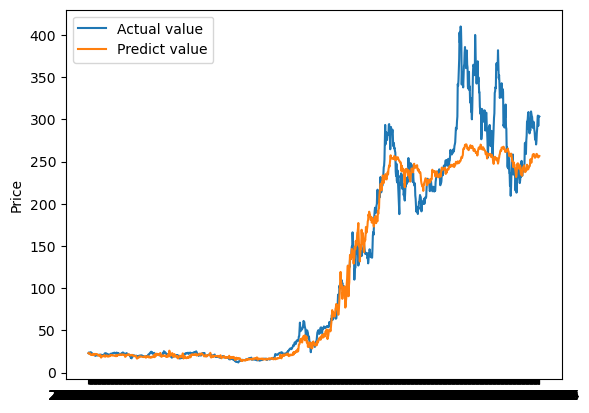

In [15]:
plt.plot(df_out["Adj Close_lead15"], label="Actual value")
plt.plot(df_out["Model forecast"], label="Predict value")
plt.ylabel("Price")
plt.legend()
plt.show()